In [2]:
import wandb
import pandas as pd
from loguru import logger
from tqdm import tqdm
from itertools import product
import numpy as np
from pathlib import Path
import functools
import json
from typing import Literal
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
import math
from typing import Literal, Optional

from histaug.utils import RunningStats, cached_df, savefig, rc_context
from histaug.utils.display import (
    RENAME_MODELS,
    RENAME_FEATURE_EXTRACTORS,
    RENAME_FEATURE_EXTRACTORS_WITH_REFERENCES,
    RENAME_TARGETS,
    TARGET_GROUPS,
    RENAME_AUGMENTATION_GROUPS,
    RENAME_MAGNIFICATIONS,
)
from histaug.analysis.collect_results import load_results

api = wandb.Api()

INDEX_COLS = [
    "magnification",
    "target",
    "train_dataset",
    "test_dataset",
    "model",
    "feature_extractor",
    "augmentations",
    "seed",
]

RESULTS_DIR = Path("/app/results")
JOURNAL = True

# Collect results from `wandb`

In [3]:
df = df_all = load_results().drop_duplicates().droplevel(["train_dataset", "test_dataset"])

df = (
    df.reset_index()
    .groupby(["magnification", "target", "model", "feature_extractor", "augmentations"])
    .filter(lambda x: sorted(x.seed.values) == list(range(5)))
    .set_index(df.index.names)
    .sort_index()
)
print("Removed runs:", len(df_all) - len(df))
print(
    df_all.index.difference(df.index)
    .to_frame(index=False)
    .groupby([x for x in df.index.names if x != "seed"])
    .seed.count()
)

2024-05-27 16:27:42.153 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading results from cache


Removed runs: 0
Series([], Name: seed, dtype: int64)


In [16]:
def compute_overall_average(df):
    # Computer overall mean and std (across targets)
    targets = df.columns.get_level_values("target").unique()
    assert "average" not in targets
    n_targets = len(targets)
    overall_mean = df.stack().query("stats == 'mean'").droplevel("stats").sum(axis="columns").divide(n_targets)
    overall_std = (
        df.stack().query("stats == 'std'").droplevel("stats").pow(2).sum(axis="columns").divide(n_targets).pow(0.5)
    )
    df["average", "mean"] = overall_mean
    df["average", "std"] = overall_std
    return df


def results_to_latex(r, goal: Optional[Literal["min", "max"]] = "min"):
    # Format for appearance
    r = r.unstack(["magnification", "model", "augmentations"])
    means = r.stack("stats").query("stats == 'mean'").droplevel("stats")
    stds = r.stack("stats").query("stats == 'std'").droplevel("stats")

    has_average = "average" in means.columns

    formatted = means.map(lambda x: f"{x:.2f}") + " \\pm " + stds.map(lambda x: f"{x:.2f}")

    # Average should be 3 decimal places
    if JOURNAL and has_average:
        formatted["average"] = (
            means["average"].map(lambda x: f"{x:.3f}") + " \\pm " + stds["average"].map(lambda x: f"{x:.3f}")
        )

    if goal:
        # Make best model bold
        best_mask = means == getattr(means, goal)(axis="index")
        formatted[best_mask] = "\\mathbf{" + formatted[best_mask] + "}"
    formatted = "$" + formatted + "$"
    formatted = formatted.stack("model")
    formatted = formatted.swaplevel("feature_extractor", "model").sort_index()

    formatted = formatted.stack(["magnification", "augmentations"])

    # Set index order to augmentations, model, feature_extractor
    formatted = formatted.reorder_levels(["magnification", "augmentations", "model", "feature_extractor"]).reindex(
        [*RENAME_TARGETS.keys(), *(["average"] if has_average else [])], axis=1
    )

    def sort_df_index(df, keys):
        """Sort a dataframe by index level values.

        Args:
            df: Dataframe to sort.
            keys: dict of {level: order} where:
                level: Name of index level to sort by.
                order: List of values in the order you want them to appear in that level
        """

        return df.sort_index(key=lambda x: x.map({v: i for i, v in enumerate(keys[x.name])}) if x.name in keys else x)

    def rename_df(df):
        rename_levels = {
            "magnification": "Magnification",
            "feature_extractor": "Feature extractor",
            "model": "Model",
            "augmentations": "Augmentations",
            "target": "Target",
        }
        for axis in [0, 1]:
            d = df.index if axis == 0 else df.columns
            for level in d.names:
                if level == "feature_extractor":
                    df = df.rename(RENAME_FEATURE_EXTRACTORS_WITH_REFERENCES, level=level, axis=axis)
                elif level == "model":
                    df = df.rename(RENAME_MODELS, level=level, axis=axis)
                elif level == "augmentations":
                    df = df.rename(RENAME_AUGMENTATION_GROUPS, level=level, axis=axis)
                elif level == "target":
                    df = df.rename(RENAME_TARGETS, level=level, axis=axis)
                elif level == "magnification":
                    df = df.rename(RENAME_MAGNIFICATIONS, level=level, axis=axis)

        df.index.set_names([rename_levels.get(x, x) for x in df.index.names], inplace=True)
        df.columns.set_names([rename_levels.get(x, x) for x in df.columns.names], inplace=True)
        return df

    formatted = sort_df_index(
        formatted,
        {
            "magnification": RENAME_MAGNIFICATIONS.keys(),
            "augmentations": RENAME_AUGMENTATION_GROUPS.keys(),
            "model": RENAME_MODELS.keys(),
            "feature_extractor": RENAME_FEATURE_EXTRACTORS_WITH_REFERENCES.keys(),
        },
    )

    only_one_magnification = len(formatted.index.unique("magnification")) == 1
    if only_one_magnification:
        formatted = formatted.droplevel("magnification")

    only_one_augmentation = len(formatted.index.unique("augmentations")) == 1
    if only_one_augmentation:
        formatted = formatted.droplevel("augmentations")

    formatted = rename_df(formatted).rename(columns={"average": "Average"})

    col_format = (
        ("" if only_one_magnification else "l")
        + ("" if only_one_augmentation else "l")
        + "ll|"
        + "|".join(("c" * len(group) for group in TARGET_GROUPS.values()))
        + ("|c" if has_average else "")
    )
    return formatted.to_latex(escape=False, column_format=col_format, multicolumn_format="c")

## Total training time

In [17]:
def gpu_summary(df):
    gpu_hours = df.runtime.sum() / 60 / 60
    return f"{gpu_hours:.1f}h ({gpu_hours / 24:.1f} days)"


print("Low magnification:", gpu_summary(df.query("magnification == 'low'")))
print("High magnification:", gpu_summary(df.query("magnification == 'high'")))
print("Total:", gpu_summary(df))

Low magnification: 5990.1h (249.6 days)
High magnification: 2149.8h (89.6 days)
Total: 8139.9h (339.2 days)


## Show results

In [18]:
d = (
    df["test_auroc"]
    .groupby(["magnification", "augmentations", "model", "feature_extractor", "target"])
    .agg(["mean", "std"])
)
d.columns.name = "stats"
d = d.unstack("target").reorder_levels(["target", "stats"], axis=1).sort_index(axis=1)
# d = compute_overall_average(d)
d

target                                                              BRAF  \
stats                                                               mean   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.438697   
                                             ctranspath         0.663697   
                                             dino_p16           0.732114   
                                             mocov2             0.716622   
                                             owkin              0.691157   
...                                                                  ...   
low           simple_rotate     Transformer  swin               0.559441   
                                             uni                0.702128   
                                             vit                0.611370   
                                             vitl               0.490359   
                                             vits               0.588697   

target                                                                    \
stats                                                                std   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.028773   
                                             ctranspath         0.027650   
                                             dino_p16           0.065682   
                                             mocov2             0.019782   
                                             owkin              0.040515   
...                                                                  ...   
low           simple_rotate     Transformer  swin               0.091344   
                                             uni                0.040191   
                                             vit                0.066482   
                                             vitl               0.089483   
                                             vits               0.051542   

target                                                              CDH1  \
stats                                                               mean   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.652656   
                                             ctranspath         0.704055   
                                             dino_p16           0.742319   
                                             mocov2             0.654540   
                                             owkin              0.760594   
...                                                                  ...   
low           simple_rotate     Transformer  swin               0.698458   
                                             uni                0.769674   
                                             vit                0.718275   
                                             vitl               0.735351   
                                             vits               0.761508   

target                                                                    \
stats                                                                std   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.013032   
                                             ctranspath         0.047242   
                                             dino_p16           0.020883   
                                             mocov2             0.031060   
                                             owkin              0.034850   
...                                                                  ...   
low           simple_rotate     Transformer  swin               0.033697   
                                             

In [19]:
TABLES_DIR = Path("/app/figures/tables")
if JOURNAL:
    TABLES_DIR = TABLES_DIR / "journal"
TABLES_DIR.mkdir(exist_ok=True, parents=True)

for magnification in RENAME_MAGNIFICATIONS.keys():
    for augmentations in RENAME_AUGMENTATION_GROUPS.keys():
        subset = d.query(f"magnification == @magnification and augmentations == @augmentations")
        if len(subset) == 0:
            logger.debug(f"No data for {magnification=} {augmentations=}; skipping")
            continue
        latex = results_to_latex(subset, goal="max")
        outfile = TABLES_DIR / f"mean_auroc__mag_{magnification}__aug_{augmentations}.tex"
        outfile.write_text(latex)

2024-05-27 16:33:45.721 | DEBUG    | __main__:<module>:10 - No data for magnification='high' augmentations='Macenko_slidewise'; skipping
2024-05-27 16:33:45.726 | DEBUG    | __main__:<module>:10 - No data for magnification='high' augmentations='all'; skipping
2024-05-27 16:33:45.732 | DEBUG    | __main__:<module>:10 - No data for magnification='high' augmentations='simple_rotate'; skipping


# What is the best feature extractor?

In [20]:
from histaug.analysis.collect_results import compute_results_table

r = (
    compute_results_table(
        df["test_auroc"], keep_fixed=("magnification", "augmentations", "model", "target"), vary="feature_extractor"
    )
    .stack("feature_extractor")
    .unstack("target")
    .swaplevel("target", "stats", axis=1)
    .sort_index(axis=1)
)
r

2024-05-27 16:33:46.910 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading norm_diff__feature_extractor__magnification_augmentations_model_target from cache


target                                                              BRAF  \
stats                                                               mean   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.336833   
                                             ctranspath         0.111833   
                                             dino_p16           0.043415   
                                             mocov2             0.058907   
                                             owkin              0.084373   
...                                                                  ...   
low           simple_rotate     Transformer  swin               0.212363   
                                             uni                0.069677   
                                             vit                0.160435   
                                             vitl               0.281446   
                                             vits               0.183108   

target                                                                    \
stats                                                                std   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.033688   
                                             ctranspath         0.032926   
                                             dino_p16           0.055144   
                                             mocov2             0.027749   
                                             owkin              0.042184   
...                                                                  ...   
low           simple_rotate     Transformer  swin               0.087714   
                                             uni                0.047326   
                                             vit                0.067488   
                                             vitl               0.086166   
                                             vits               0.056072   

target                                                              CDH1  \
stats                                                               mean   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.154779   
                                             ctranspath         0.103379   
                                             dino_p16           0.065116   
                                             mocov2             0.152894   
                                             owkin              0.046840   
...                                                                  ...   
low           simple_rotate     Transformer  swin               0.119977   
                                             uni                0.048761   
                                             vit                0.100160   
                                             vitl               0.083084   
                                             vits               0.056927   

target                                                                    \
stats                                                                std   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.026310   
                                             ctranspath         0.048391   
                                             dino_p16           0.030080   
                                             mocov2             0.036443   
                                             owkin              0.035973   
...                                                                  ...   
low           simple_rotate     Transformer  swin               0.041337   
                                             

In [21]:
r = compute_overall_average(r)

for magnification in RENAME_MAGNIFICATIONS.keys():
    for augmentations in RENAME_AUGMENTATION_GROUPS.keys():
        subset = r.query(f"magnification == @magnification and augmentations == @augmentations")
        if len(subset) == 0:
            logger.debug(f"No data for {magnification=} {augmentations=}; skipping")
            continue
        latex = results_to_latex(subset, goal="min")
        outfile = TABLES_DIR / f"norm_diff_auroc__mag_{magnification}__aug_{augmentations}.tex"
        outfile.write_text(latex)

2024-05-27 16:33:49.766 | DEBUG    | __main__:<module>:7 - No data for magnification='high' augmentations='Macenko_slidewise'; skipping
2024-05-27 16:33:49.771 | DEBUG    | __main__:<module>:7 - No data for magnification='high' augmentations='all'; skipping
2024-05-27 16:33:49.777 | DEBUG    | __main__:<module>:7 - No data for magnification='high' augmentations='simple_rotate'; skipping


# What is the best downstream aggregation model?

2024-05-27 16:33:55.143 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading norm_diff__model__magnification_augmentations_feature_extractor_target from cache


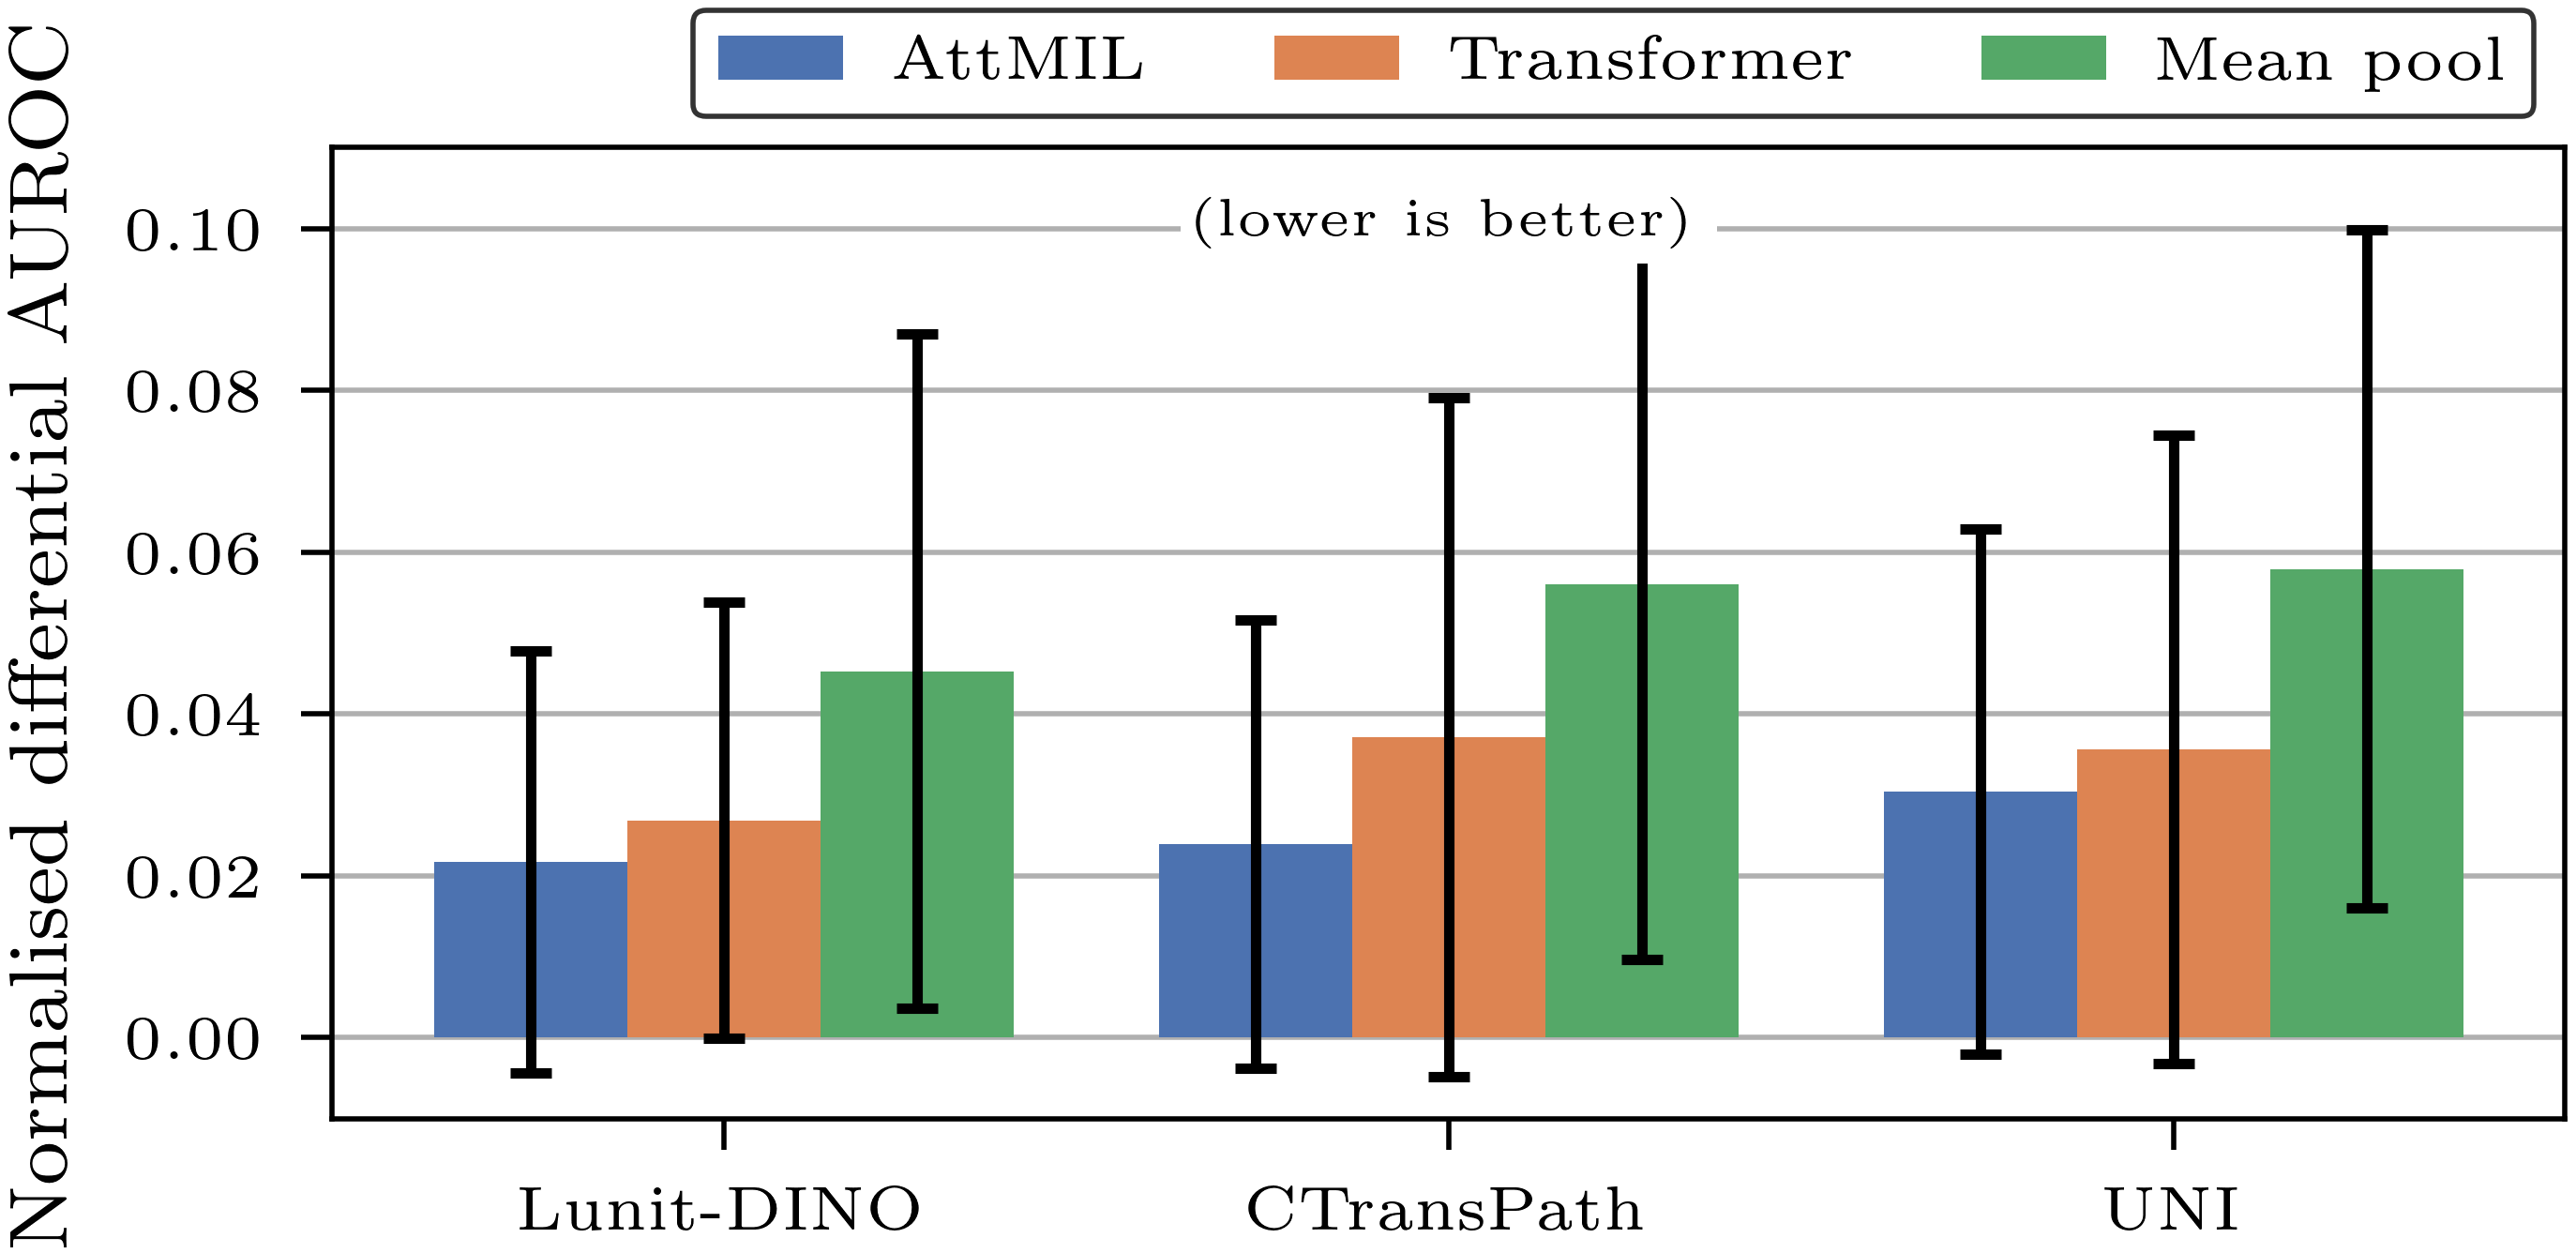

In [22]:
from histaug.analysis.collect_results import compute_results_table
import matplotlib.pyplot as plt
import seaborn as sns

magnification = "low"
augmentations = "none"
feature_extractors = RENAME_FEATURE_EXTRACTORS.keys()
feature_extractors = ["dino_p16", "ctranspath"]
if JOURNAL:
    feature_extractors += ["uni"]

r = compute_results_table(
    df["test_auroc"], keep_fixed=("magnification", "augmentations", "feature_extractor", "target"), vary="model"
)
r = r.query(
    "magnification == @magnification and augmentations == @augmentations and feature_extractor in @feature_extractors"
).droplevel(["magnification", "augmentations"])
r = r.stack("model").unstack("target").swaplevel("stats", "target", axis=1).sort_index(axis=1)
r = compute_overall_average(r)
r = r["average"]


with rc_context(**(dict(w=0.5, h=0.8, default_smaller=2) if not JOURNAL else dict(journal=True, size="half", h=0.8))):
    group_width = 0.8
    bar_width = group_width / len(RENAME_MODELS)

    # add small text at top of ax with "(lower is better)"
    plt.gca().text(
        0.5,
        0.95,
        "(lower is better)",
        horizontalalignment="center",
        verticalalignment="top",
        transform=plt.gca().transAxes,
        fontsize=5,
        # white background
        bbox=dict(facecolor="white", alpha=1.0, edgecolor="none", pad=0.3, boxstyle="square"),
    )

    for i, (model, model_name) in enumerate(RENAME_MODELS.items()):
        s = r[r.index.get_level_values("model") == model].droplevel("model")
        s = s.reindex(feature_extractors)
        means = s["mean"]
        stds = s["std"]
        plt.bar(
            np.arange(len(means)) + i * bar_width - bar_width * (len(RENAME_MODELS) - 1) / 2,
            means,
            yerr=stds,
            width=bar_width,
            label=model_name,
            capsize=2,
            color=sns.color_palette("deep")[i],
        )
    plt.xticks(np.arange(len(feature_extractors)), [RENAME_FEATURE_EXTRACTORS[x] for x in feature_extractors])
    # plt.legend(ncol=3, loc="upper center")
    # Put legend above plot
    plt.legend(
        bbox_to_anchor=(1.0, 1.0),
        loc="lower right",
        ncol=3,
        # frameon=False,
        # smaller column spacing
        # columnspacing=0.8,
    )
    plt.ylim(-0.01, 0.11)
    plt.xlabel("Feature extractor")
    plt.xlabel("")
    plt.ylabel("Norm.\ diff.\ AUROC" if not JOURNAL else "Normalised differential AUROC")
    # plt.ylabel("AUROC deterioration vs.\ best")
    # decrease ylabel font size
    # plt.gca().yaxis.label.set_size(7)
    # plt.xticks(rotation=45, ha="right")

    # horizontal grid
    plt.grid(axis="y")
    plt.yticks(np.arange(0.0, 0.11, 0.02))

    savefig(f"aggregation_comparison_aug_{augmentations}", journal=JOURNAL)
    plt.show()

# Compare magnifications

In [25]:
r = df["test_auroc"].unstack("seed").query("model == 'AttentionMIL' and augmentations in ['none', 'Macenko_patchwise']")
r = r.droplevel("model")
r = r.query("augmentations == 'none'").droplevel("augmentations")
hi = r.query("magnification == 'high'").droplevel("magnification")
lo = r.query("magnification == 'low'").droplevel("magnification")
hi = hi.reindex(lo.index)
mean = hi.mean(axis="columns") - lo.mean(axis="columns")
std = (hi.std(axis="columns").pow(2) + lo.std(axis="columns").pow(2)).pow(0.5)
data = pd.concat([mean, std], axis=1, keys=["mean", "std"])

data

mean       std
target  feature_extractor                    
BRAF    bt                 0.070745  0.152508
        ctranspath        -0.022207  0.025725
        dino_p16          -0.008777  0.054714
        mocov2            -0.028324  0.047846
        owkin             -0.004588  0.084226
...                             ...       ...
subtype swin              -0.058330  0.014673
        uni               -0.035054  0.018362
        vit               -0.050991  0.047139
        vitl              -0.054427  0.037863
        vits              -0.004507  0.027371

[126 rows x 2 columns]